# Hillslope Integrated Hydrology + Reactive Transport

## Mesh and Boundary Conditions

The hillslope domain is 1000 meters long, 45 meters thick with a slope of 0.1.

The subsurface domain has three sides of no-flow boundary conditions, and is coupled with surface domain on the top. Rain is the source terms in the flow and transport PKs. Free flow (seepage face) boundary condition is set at the hillslope toe.

<img src="./hillslope/pictures/hillslope_mesh_and_bc.png" alt="Drawing" style="width: 800px;"/>


The full simulations (hillslope_calcite_pflotran.xml and hillslope_calcite_crunch.xml) run 200 days and may take > 15 mins using two processors. The shorten simulations (hillslope_calcite_pflotran_restart.xml and hillslope_calcite_crunch_restar.xml) are restarted from a checkpoint file at day 50 to save time for running the first 50-day of drainage.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import h5py
from IPython.display import Image

## Integrated Hydrology

Periodic rainfall recharge condition, as the only source of water in the model. <br>

Velocity figure shows the flow pattern and upward velocity near the hillslope toe.
<img src="./hillslope/pictures/hillslope_flow_velocity.png" alt="Drawing" style="width: 800px;"/>


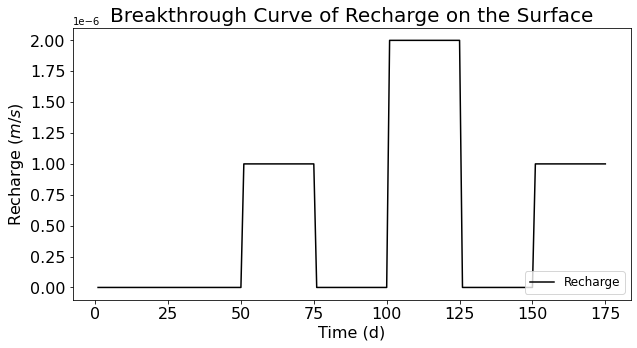

In [22]:
plt.rcParams['figure.figsize'] = [10, 5]
path='./hillslope/results/'
RECHARGE = np.loadtxt(path+'surface-water_source.dat', skiprows=12) 

plt.plot(RECHARGE[:,0]/86400, RECHARGE[:,1], 'k-', label='Recharge')
plt.title("Breakthrough Curve of Recharge on the Surface", fontsize=20)
plt.xlabel("Time (d)",fontsize=16)
plt.ylabel("Recharge ($m/s$)",fontsize=16)
plt.xticks([0,25,50,75,100,125,150,175],fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=12, loc='lower right')
plt.show()

In [9]:
# ATS raw output unit: mol/s
# Convert to m3/s
unit_convert_flow = 1.8e-5

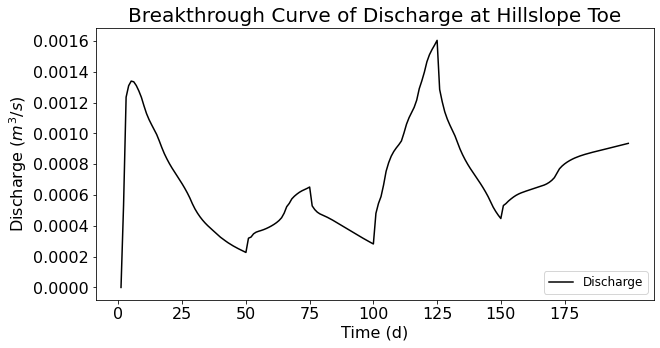

In [10]:
plt.rcParams['figure.figsize'] = [10, 5]
path='./hillslope/results/'
DISCHARGE = np.loadtxt(path+'surface_outlet_flux_crunch.dat', skiprows=12) 

plt.plot(DISCHARGE[:,0]/86400, DISCHARGE[:,1]*unit_convert_flow, 'k-', label='Discharge')
plt.title("Breakthrough Curve of Discharge at Hillslope Toe", fontsize=20)
plt.xlabel("Time (d)",fontsize=16)
plt.ylabel("Discharge ($m^3/s$)",fontsize=16)
plt.xticks([0,25,50,75,100,125,150,175],fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=12, loc='lower right')
plt.show()

## Reactive Transport

ATS supports two reactive transport models, pflotran and crunchflow. The examples with both RTM are included in this demo. <br>
Calcite is the only mineral reaction simulated in this demo. <br>

Initial condition of geochemistry in both surface and subsurface are equlibrate with Calcite (PFLOTRAN file as an example below, in ./data/1d-calcite-pflotran.in). <br>

<img src="./hillslope/pictures/pflotran_constraint.png" alt="Drawing" style="width: 300px;"/>

Initial condition of geochemistry in the rainwater is equlibrate with atmospheric CO2. <br>
<img src="./hillslope/pictures/pflotran_constraint_rain.png" alt="Drawing" style="width: 300px;"/>


In [5]:
plt.rcParams['figure.figsize'] = [10, 5]
path='./hillslope/results/'
BTC_1 = np.loadtxt(path+'surface_total_concentration_crunch.dat', skiprows=12) 
FREE_1 = np.loadtxt(path+'surface_free_ion_species_crunch.dat', skiprows=12) 

In [12]:
# ATS raw output unit: mol-species/mol-water in surface_total_concentration_crunch.dat
# Convert to micromole per liter
unit_convert_transport = 55.55e6

/tmp/ipykernel_29/679295999.py:13: RuntimeWarning: divide by zero encountered in log10
  ax2.plot(BTC_1[:,0]/86400, -np.log10(FREE_1[:,1]), 'r')


([<matplotlib.axis.XTick at 0x7fcba76ec340>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

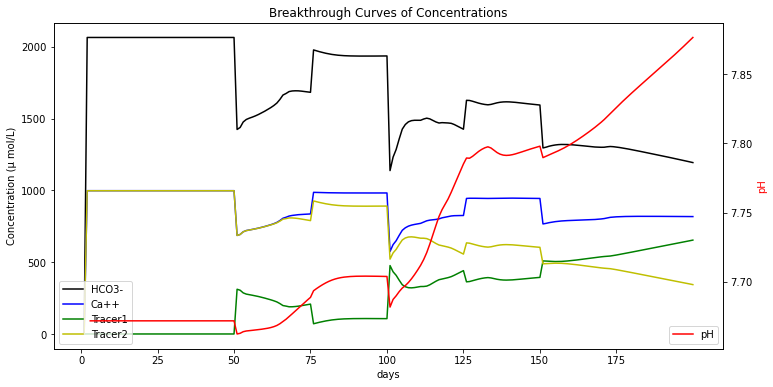

In [13]:
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(111)
ax1.set_xlabel('days')
ax1.set_ylabel('Concentration (\u03BC mol/L)', color='k')
ax1.plot(BTC_1[:,0]/86400, BTC_1[:,2]*unit_convert_transport, 'k-', BTC_1[:,0]/86400, BTC_1[:,3]*unit_convert_transport, 'b-', BTC_1[:,0]/86400, BTC_1[:,4]*unit_convert_transport, 'g-', BTC_1[:,0]/86400, BTC_1[:,5]*unit_convert_transport, 'y-')
ax1.tick_params(axis='y', labelcolor='k')
# ax1.set_ylim((600, 1000))
ax1.legend(['HCO3-','Ca++','Tracer1','Tracer2'], loc='lower left')

# For pH calculation we should use free H+ concentration
ax2 = ax1.twinx()
ax2.plot(BTC_1[:,0]/86400, -np.log10(FREE_1[:,1]), 'r')
ax2.set_ylabel('pH', color='r')
ax2.legend(['pH'], loc='lower right')

ax1.set_title('Breakthrough Curves of Concentrations')

plt.xticks([0,25,50,75,100,125,150,175])

# ax2.set_ylim((0, 10))
# ax2.set_ylim(ax2.get_ylim()[::-1])

Volume fraction of Calcite at the end of the simulation <br>
<img src="./hillslope/pictures/volume_fraction_calcite.png" alt="Drawing" style="width: 600px;"/>